Text(0.5, 1.0, 'Dataset 1')

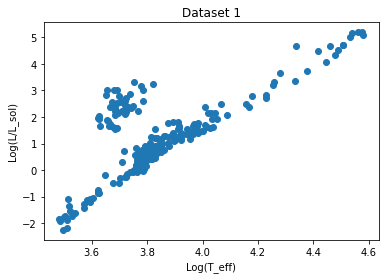

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy

df = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

#filter out erroneous values
df = df[df['logL1'] > -3]

logT1 = df["logT1"]
logT1 = np.array(logT1)
logL1 = df["logL1"]
logL1 = np.array(logL1)

plt.scatter(logT1, logL1)
plt.xlabel('Log(T_eff)')
plt.ylabel('Log(L/L_sol)')
plt.title('Dataset 1')

(array([ 2.,  4.,  4.,  2.,  6.,  3.,  1.,  4.,  8., 16., 29., 29., 23.,
        12., 17., 22., 11., 13., 16.,  8.,  7.,  5.,  5.,  1.,  1.,  1.,
         1.,  3.,  3.,  5.]),
 array([-2.258     , -2.00983333, -1.76166667, -1.5135    , -1.26533333,
        -1.01716667, -0.769     , -0.52083333, -0.27266667, -0.0245    ,
         0.22366667,  0.47183333,  0.72      ,  0.96816667,  1.21633333,
         1.4645    ,  1.71266667,  1.96083333,  2.209     ,  2.45716667,
         2.70533333,  2.9535    ,  3.20166667,  3.44983333,  3.698     ,
         3.94616667,  4.19433333,  4.4425    ,  4.69066667,  4.93883333,
         5.187     ]),
 <BarContainer object of 30 artists>)

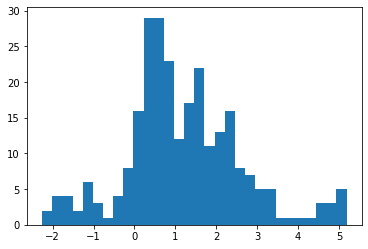

In [3]:
plt.hist(logL1, bins=30)

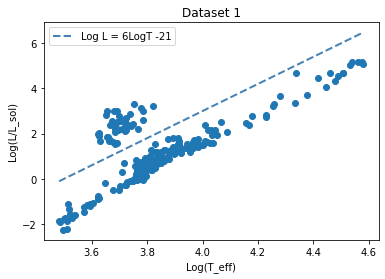

In [4]:
x = np.arange(3.5, 4.6, 0.01)
y = 6*x - 21
plt.scatter(logT1, logL1)
#plt.plot(x, y, color='steelblue', linestyle='--', linewidth=2)
plt.plot(logT1, 6*logT1 -21, color='steelblue', linestyle='--', linewidth=2,label = 'Log L = 6LogT -21')
plt.xlabel('Log(T_eff)')
plt.ylabel('Log(L/L_sol)')
plt.title('Dataset 1')
plt.legend()

In [5]:
#Filtered out the red giants data, which are the data above the line of best fit 
logT1_cut = logT1[logL1 < (6*logT1-21)]
logL1_cut = logL1[logL1 < (6*logT1-21)]

#filter the errors as well
logT1_err = df['logT1e'][logL1 < (6*logT1-21)]
logL1_err = df['logL1e'][logL1 < (6*logT1-21)]
logT1_err = np.array(logT1_err)
logL1_err = np.array(logL1_err)

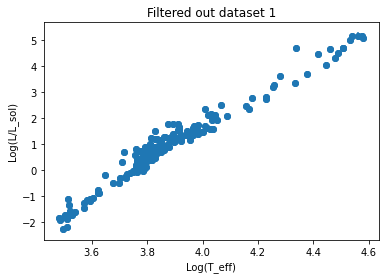

In [6]:
plt.scatter(logT1_cut, logL1_cut)
plt.errorbar(logT1_cut, logL1_cut, yerr=logL1_err, fmt="o")
plt.xlabel('Log(T_eff)')
plt.ylabel('Log(L/L_sol)')
plt.title('Filtered out dataset 1')
plt.show()

#error bars on values are so small they hardly show up on the scatter plot
#and they're already transformed in log space so that's not an issue either

In [6]:
import sklearn
from scipy.stats import poisson
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc as pm

In [7]:
from pymc import Model, Normal, Gamma

# Without Known Errors

In [8]:
y = logL1_cut
x1 = logT1_cut

In [31]:
# one that does not include errors
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    beta = Normal('beta', mu=0, tau=1./1000, shape=2)
    precision = Gamma('precision', alpha=0.5, beta=0.5)
    # Expected value of outcome
    mu = beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [32]:
from pymc import find_MAP
#import pprint
#pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
map_estimate

{'beta': array([-23.60795949,   6.33604984]),
 'precision_log__': array(2.4255216),
 'precision': array(11.30812616)}

In [33]:
with basic_model:
    start = find_MAP() 
    # draw "draws" posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)

/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/2193295253.py:4: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 89 seconds.


In [34]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 10000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -24.01 6.439 ... -23.63 6.338
    precision   (chain, draw) float64 11.23 11.52 11.12 ... 12.54 12.44 12.39
Attributes:
    created_at:                 2022-11-23T03:25:27.326852
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              88.79518675804138
    tuning_steps:               1000

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'precision'}>,
        <AxesSubplot:title={'center':'precision'}>]], dtype=object)

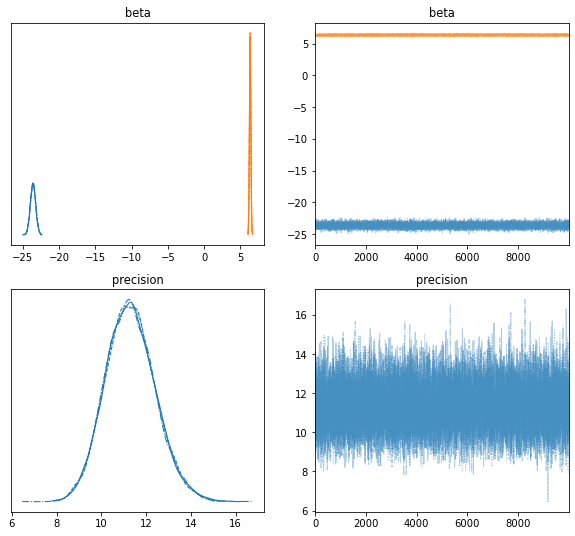

In [35]:
az.plot_trace(trace,figsize=(10, 9))

In [17]:
az.summary(trace, hdi_prob=0.95) # HDI Highest Density Interval 5%

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-23.607,0.363,-24.315,-22.893,0.003,0.002,11401.0,13338.0,1.0
beta[1],6.336,0.094,6.152,6.519,0.001,0.001,11381.0,13352.0,1.0
precision,11.298,1.094,9.260,13.534,0.008,0.006,17434.0,15924.0,1.0


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'precision'}>], dtype=object)

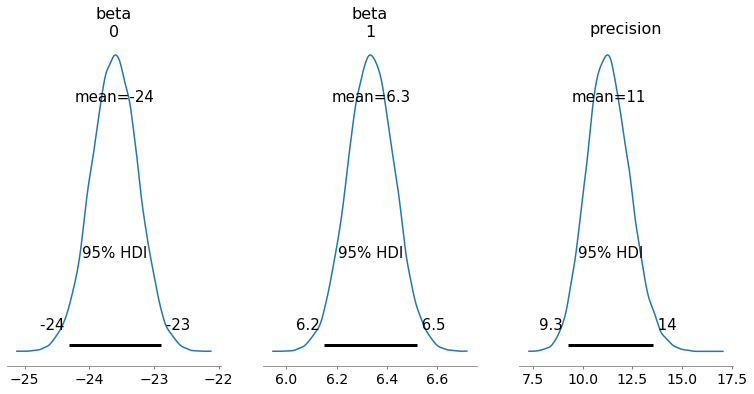

In [18]:
az.plot_posterior(trace, figsize=(13, 6), hdi_prob=0.95)

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'precision'}>], dtype=object)

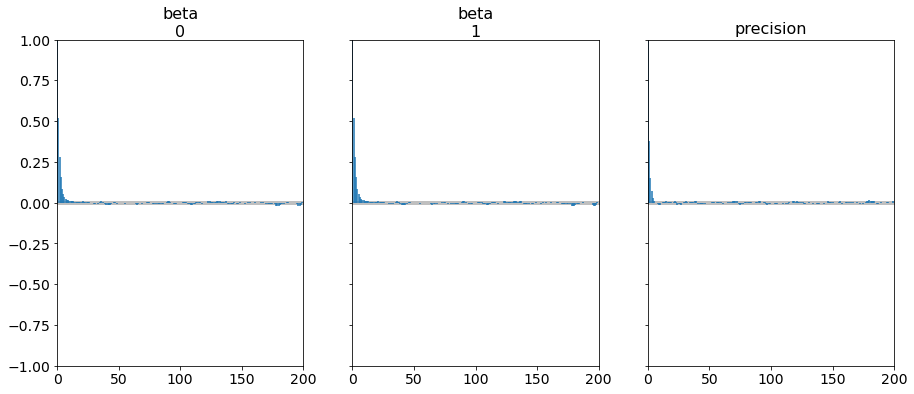

In [20]:
az.plot_autocorr(trace, var_names=['precision','beta'], filter_vars="like",  max_lag=200, combined=True, figsize=(15, 6))

In [21]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 4, draw: 10000, Y_obs_dim_2: 212)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -1.638 -1.361 ... 5.202
Attributes:
    created_at:                 2022-11-23T03:17:34.572417
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<AxesSubplot:xlabel='Y_obs / Y_obs'>

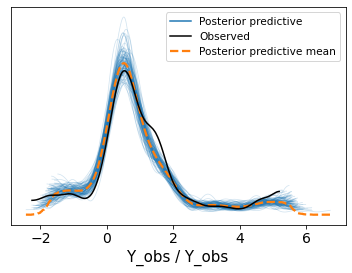

In [22]:
az.plot_ppc(trace,num_pp_samples=100)

In [23]:
az.summary(trace.posterior_predictive, hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Y_obs[0],-1.542,0.303,-2.121,-0.939,0.002,0.001,38629.0,38951.0,1.0
Y_obs[1],-1.457,0.303,-2.047,-0.859,0.002,0.001,39097.0,39927.0,1.0
Y_obs[2],-1.368,0.302,-1.959,-0.772,0.002,0.001,39092.0,39253.0,1.0
Y_obs[3],-1.336,0.301,-1.943,-0.762,0.002,0.001,39251.0,39169.0,1.0
Y_obs[4],-1.522,0.303,-2.106,-0.918,0.002,0.001,38729.0,39681.0,1.0
...,...,...,...,...,...,...,...,...,...
Y_obs[207],5.371,0.307,4.770,5.978,0.002,0.001,34822.0,37132.0,1.0
Y_obs[208],5.098,0.306,4.502,5.695,0.002,0.001,37155.0,38297.0,1.0
Y_obs[209],5.144,0.306,4.547,5.748,0.002,0.001,36751.0,38630.0,1.0
Y_obs[210],5.276,0.304,4.663,5.859,0.002,0.001,37764.0,39466.0,1.0


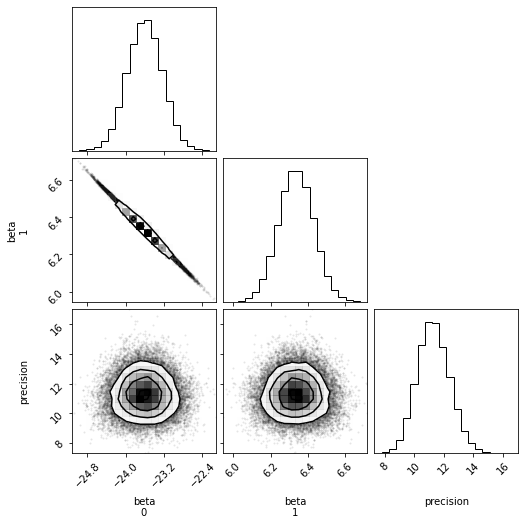

In [24]:
import corner
figure =  corner.corner(trace,varnames=["precision", "beta"],divergences=True )

Text(0, 0.5, 'Standardized residual')

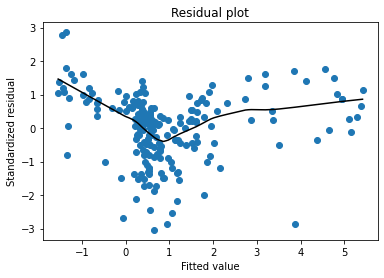

In [28]:
#Producing the standardized residual plots
import statsmodels.api as sm


X = np.matrix([np.ones(x.shape[0]),x]).T
temp = np.ones(len(y))
X_matrix = np.matrix([temp,x1]).T
#Coefficients array, which contain beta_0 and beta_1 using their mean posterior density
coef_array = np.array((np.mean(trace.posterior["beta"][1,:,0]),np.mean(trace.posterior["beta"][1,:,1])))

fittedY = X_matrix*coef_array[:,None]
#Calculating the residual by subtracting the fitted value by the data
resids = fittedY - y[:,None]
#standardized the residuals
sresids = resids/np.std(resids)

fittedY= fittedY.T
fittedY = np.array((fittedY[0,:]))
fittedY = fittedY[0,:]

sresids = np.array((sresids[:,0]))
sresids = sresids[:,0]


plt.scatter(fittedY,sresids)
#Including the lowess fit
lowess = sm.nonparametric.lowess
fitting=lowess(sresids,fittedY)
plt.plot(fitting[:,0], fitting[:,1], color='black')

plt.plot()
plt.title("Residual plot")
plt.xlabel('Fitted value')
plt.ylabel('Standardized residual')

## Sensitivity check for no errors models:

In [12]:
from pymc import find_MAP

a=np.array([0, 0, 0, 5, 5])
b=np.array([1e-3,1e-3, 1e-1 ,1e-3, 1e-1])
c=np.array([0.5, 1,0.5,0.5,1])
d=np.array([0.5,1,0.5,0.5,1])
Posteriors = []
for i in range(a.shape[0]):
    basic_model_set2 = Model()

    with basic_model_set2:
        #priors for unknown model parameters
        beta = Normal('beta', mu=a[i], tau=b[i], shape=2)
        precision = Gamma('precision', alpha=c[i], beta=d[i])
        
        #expected value of outcome
        mu = beta[0] + beta[1]*x1
        
        #likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

    map_estimate_set2 = find_MAP(model=basic_model_set2)

    with basic_model_set2:
        start_set2 = find_MAP()
        
        #draw 1000 posterior samples
        trace_set2 = pm.sample(start=start_set2, return_inferencedata=True, draws=1000)

    Posteriors.append(trace_set2.posterior)



/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/2958666729.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(start=start_set2, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/2958666729.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(start=start_set2, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/2958666729.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(start=start_set2, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/2958666729.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(start=start_set2, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/2958666729.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(start=start_set2, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'precision'}>], dtype=object)

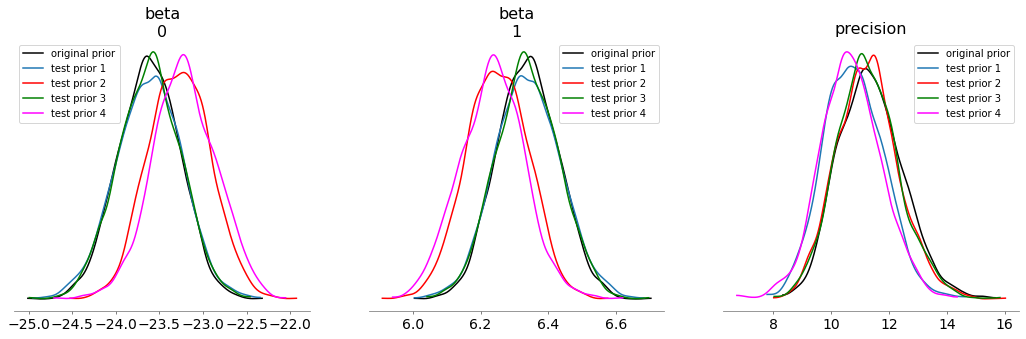

In [13]:
ax1 = az.plot_posterior(Posteriors[0], color='black', hdi_prob='hide', point_estimate=None, label='original prior', figsize=(18,5))
az.plot_posterior(Posteriors[1], ax=ax1, hdi_prob='hide', point_estimate=None, label='test prior 1')
az.plot_posterior(Posteriors[2], ax=ax1, color='red', hdi_prob='hide', point_estimate=None, label='test prior 2')
az.plot_posterior(Posteriors[3], ax=ax1, color='green', hdi_prob='hide', point_estimate=None, label='test prior 3')
az.plot_posterior(Posteriors[4], ax=ax1, color='magenta', hdi_prob='hide', point_estimate=None, label='test prior 4')

# With Known Errors

In [29]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = d = 1e-3
e = f = 0.5

In [36]:
basic_model2 = Model()

with basic_model2:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

In [37]:
from pymc import find_MAP
import pprint
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model2)
pp.pprint(map_estimate)


{   'X1': array([3.48291212, 3.49588595, 3.50997077, 3.51495035, 3.48553271,
       3.51286992, 3.52797818, 3.49965137, 3.5038363 , 3.53858143,
       3.51799558, 3.5719684 , 3.52188199, 3.59290668, 3.57189654,
       3.60497308, 3.58191932, 3.59286311, 3.62793119, 3.62371402,
       3.79598103, 3.62293351, 3.69878016, 3.78393204, 3.78996128,
       3.62276712, 3.78495806, 3.77198043, 3.79298461, 3.78694413,
       3.67687413, 3.78895612, 3.72581707, 3.77999475, 3.77499552,
       3.74892278, 3.72797741, 3.70189366, 3.75996286, 3.72084775,
       3.76394546, 3.7399575 , 3.7509545 , 3.75395686, 3.77696311,
       3.64996379, 3.7869958 , 3.7599381 , 3.76292636, 3.77195118,
       3.7709745 , 3.77296718, 3.76399314, 3.77495471, 3.76697799,
       3.7729866 , 3.78198328, 3.77097777, 3.7879697 , 3.77794084,
       3.77096736, 3.77498857, 3.80099724, 3.78098699, 3.80399122,
       3.78296983, 3.77799032, 3.79293211, 3.79199812, 3.76388957,
       3.7839954 , 3.79596068, 3.791974  , 3.814867

In [41]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model2:
    start = find_MAP() 
    #step = pm.Metropolis()
    # draw 10000 posterior samples
    trace2 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000) # step=step

# These general samplers take too long.
# The dimension is too high due to X and Y random vectors.
# Suggest using the Gibbs samplers in R with code provided in LinearRegressionME.pdf page 11. 

Running on PyMC v4.3.0


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/269499646.py:13: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace2 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 140 seconds.


In [42]:
# Get the posterior dataset
posterior = trace2.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 10000, X1_dim_0: 212, beta_dim_0: 2,
                 Y_dim_0: 212)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * X1_dim_0    (X1_dim_0) int64 0 1 2 3 4 5 6 7 ... 205 206 207 208 209 210 211
  * beta_dim_0  (beta_dim_0) int64 0 1
  * Y_dim_0     (Y_dim_0) int64 0 1 2 3 4 5 6 7 ... 205 206 207 208 209 210 211
Data variables:
    X1          (chain, draw, X1_dim_0) float64 3.471 3.505 ... 4.536 4.586
    beta        (chain, draw, beta_dim_0) float64 -19.18 5.195 ... -23.62 6.321
    Y           (chain, draw, Y_dim_0) float64 -1.735 -2.246 ... 5.168 5.111
    tau         (chain, draw) float64 0.14 0.1323 0.1313 ... 0.1297 0.1355
Attributes:
    created_at:                 2022-11-23T03:31:54.637918
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              139.8428919315338
    tuning_steps:               1000

array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

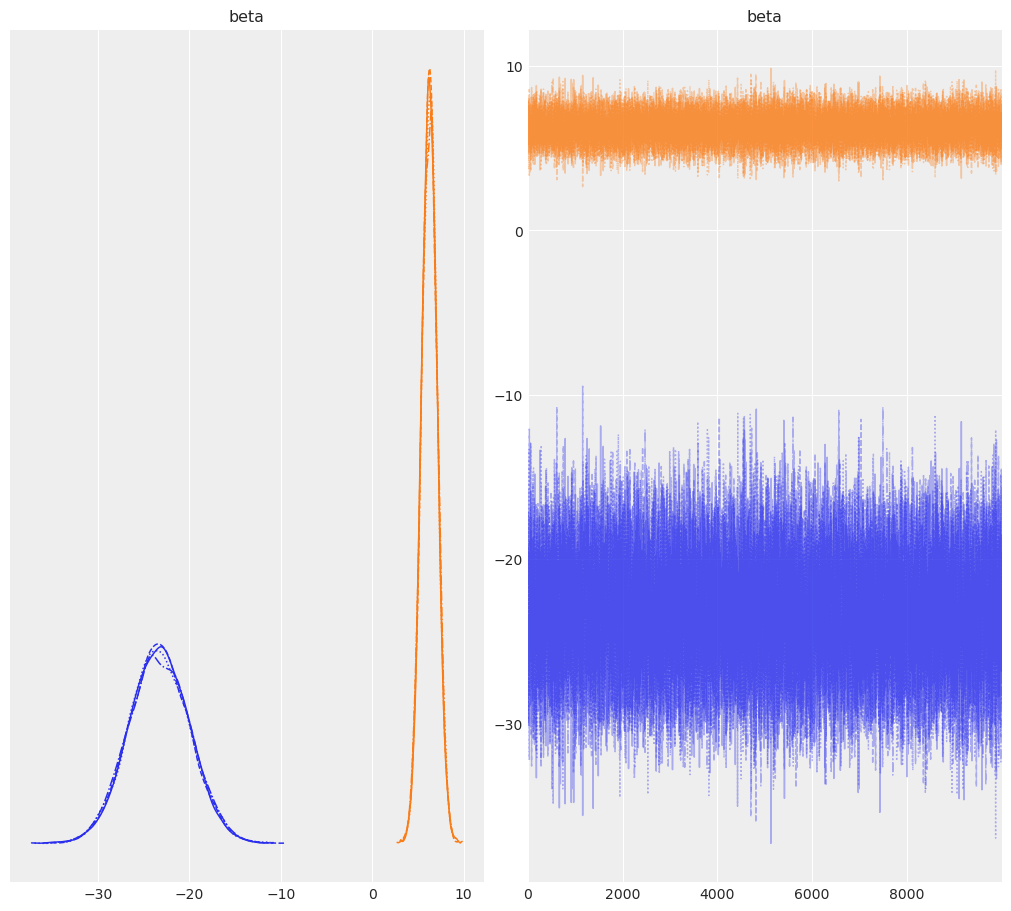

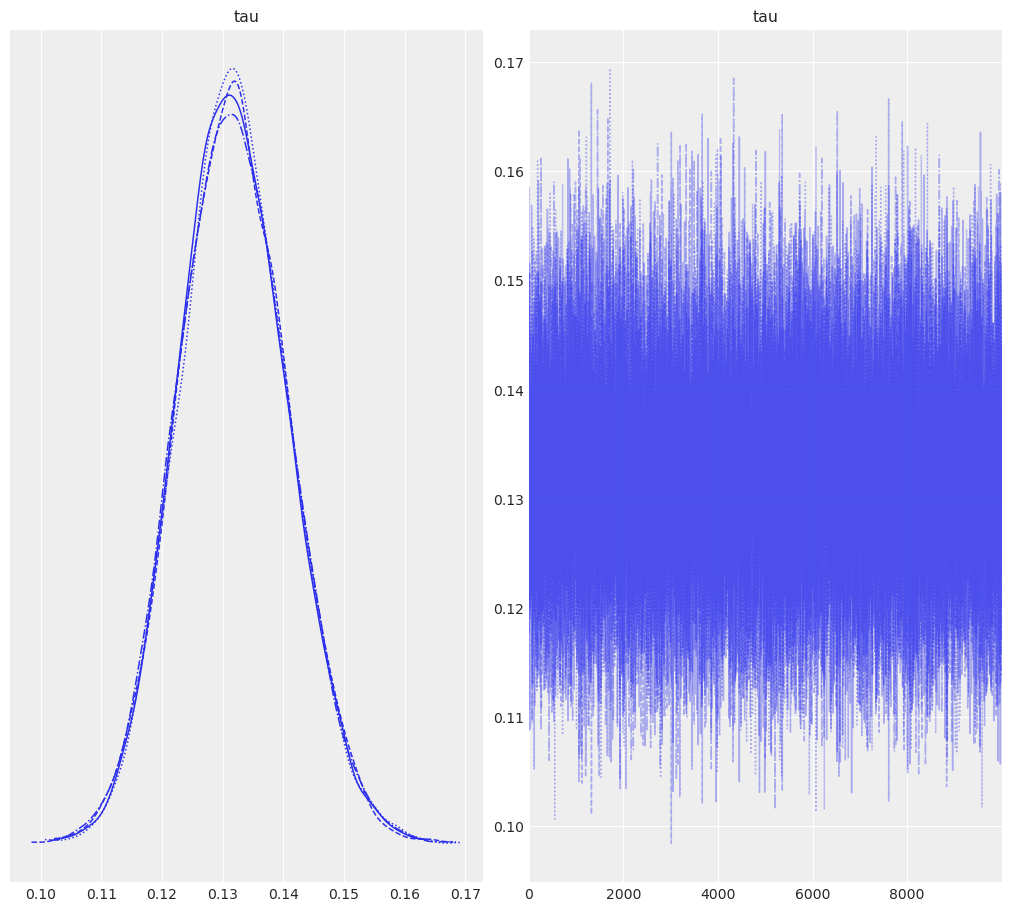

In [43]:
az.plot_trace(trace2.posterior["beta"],figsize=(10, 9))
az.plot_trace(trace2.posterior["tau"],figsize=(10, 9))

In [44]:
az.summary(trace2.posterior[["beta","tau"]], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-23.299,3.321,-29.666,-16.630,0.021,0.015,25861.0,29511.0,1.0
beta[1],6.256,0.857,4.591,7.952,0.005,0.004,25873.0,29203.0,1.0
tau,0.132,0.009,0.115,0.150,0.000,0.000,50457.0,29123.0,1.0


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'tau'}>], dtype=object)

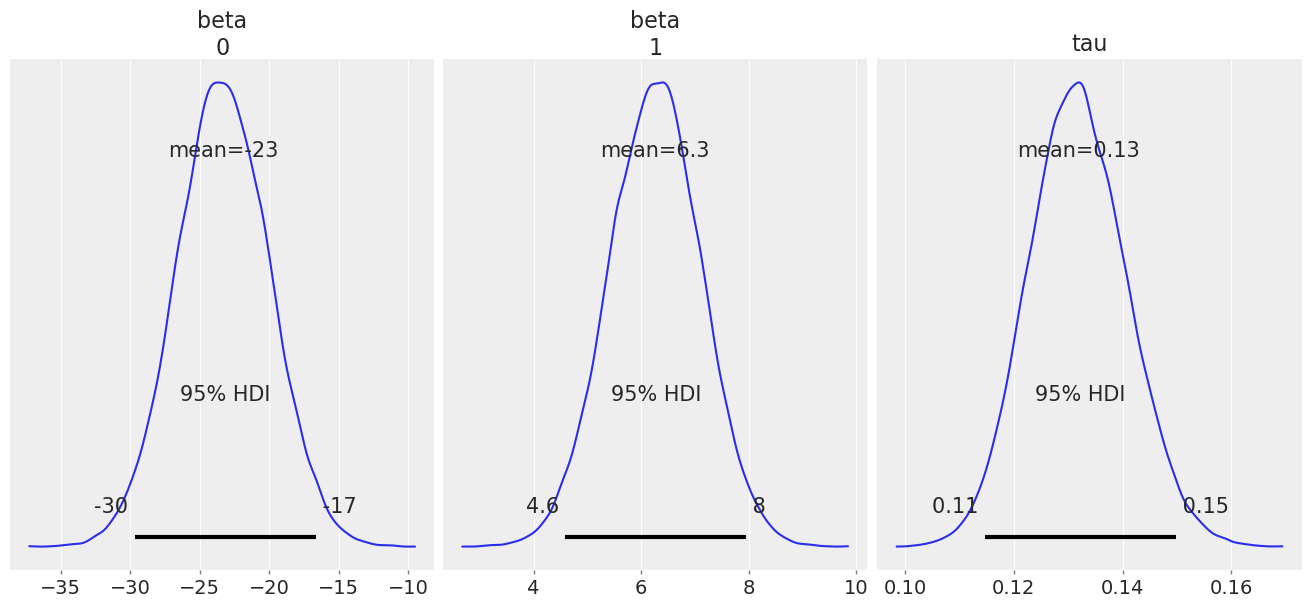

In [46]:
az.plot_posterior(trace2.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'tau'}>], dtype=object)

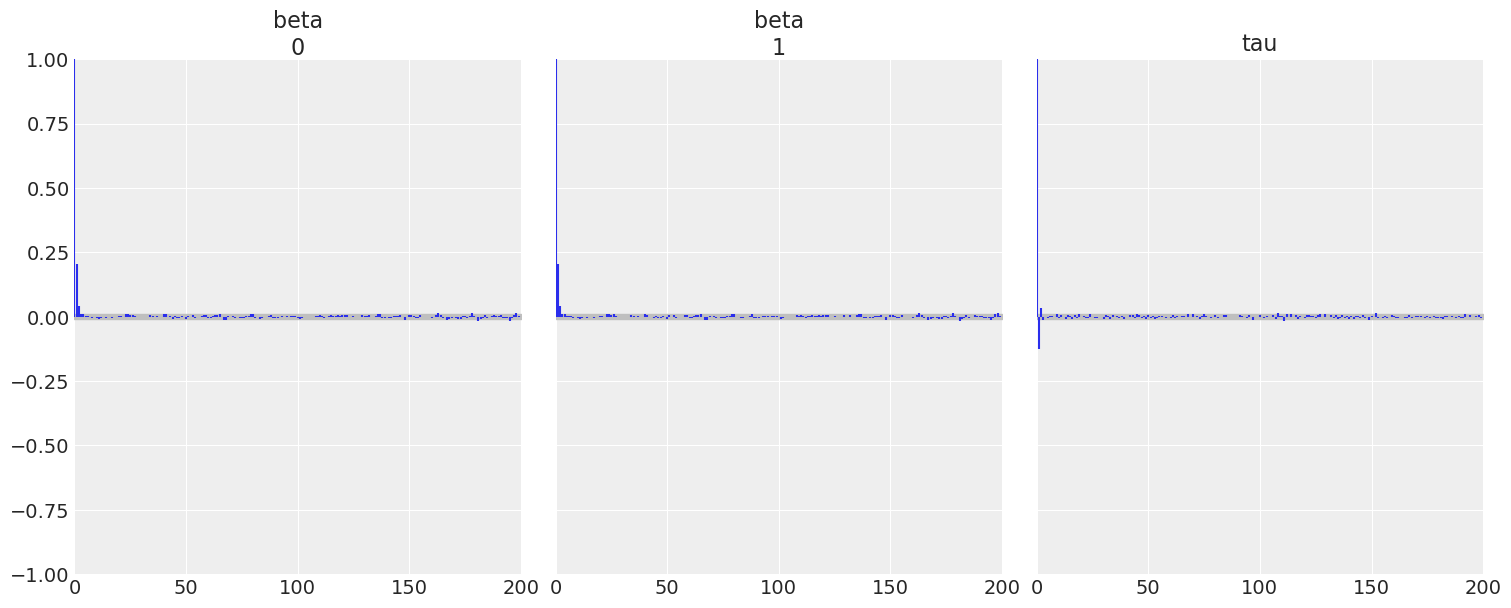

In [48]:
az.plot_autocorr(trace2, var_names=['tau','beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))


In [49]:
# Posterior Predictive Sampling
with basic_model2:
    pm.sample_posterior_predictive(trace2, extend_inferencedata=True)

trace2.posterior_predictive

Sampling: [X_star, Y_star]


<xarray.Dataset>
Dimensions:       (chain: 4, draw: 10000, Y_star_dim_2: 212, X_star_dim_2: 212)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * Y_star_dim_2  (Y_star_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
  * X_star_dim_2  (X_star_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
Data variables:
    Y_star        (chain, draw, Y_star_dim_2) float64 -1.792 -2.256 ... 5.104
    X_star        (chain, draw, X_star_dim_2) float64 3.481 3.49 ... 4.56 4.594
Attributes:
    created_at:                 2022-11-23T03:33:26.835564
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0

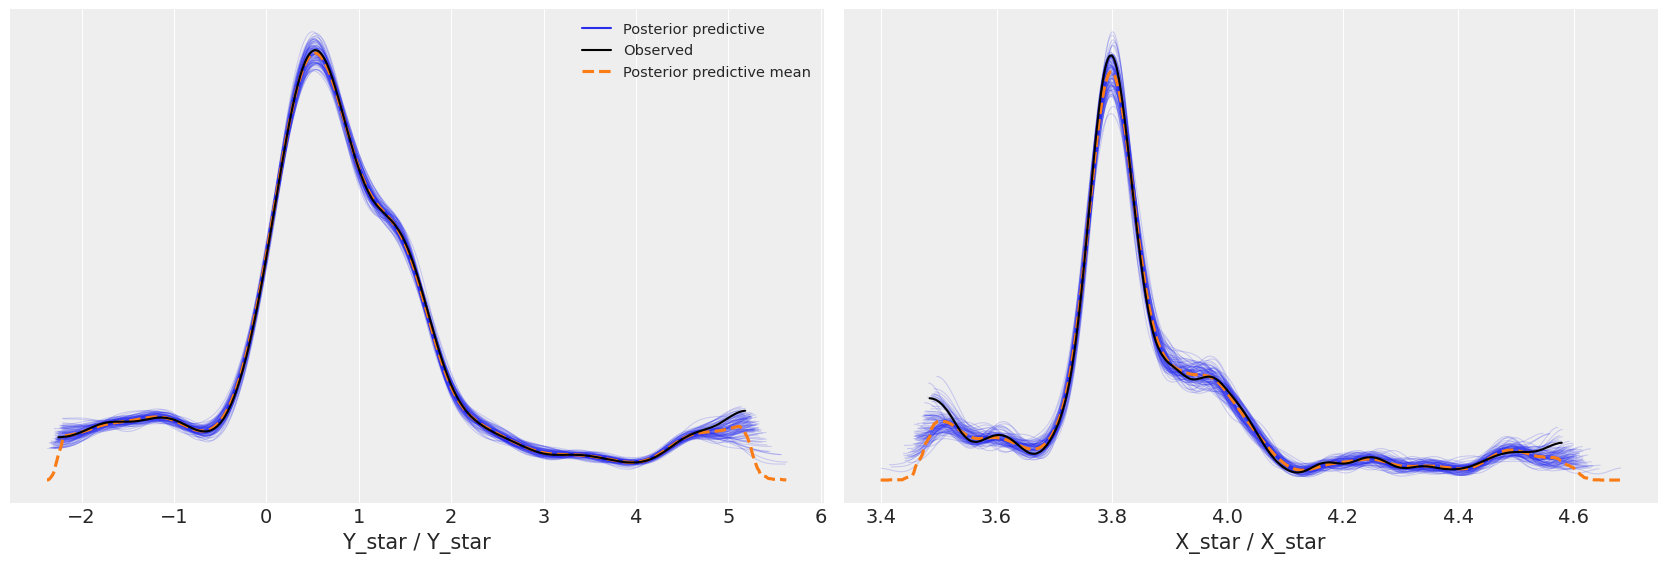

In [50]:
az.plot_ppc(trace2, num_pp_samples=100);

/Users/kietpham/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


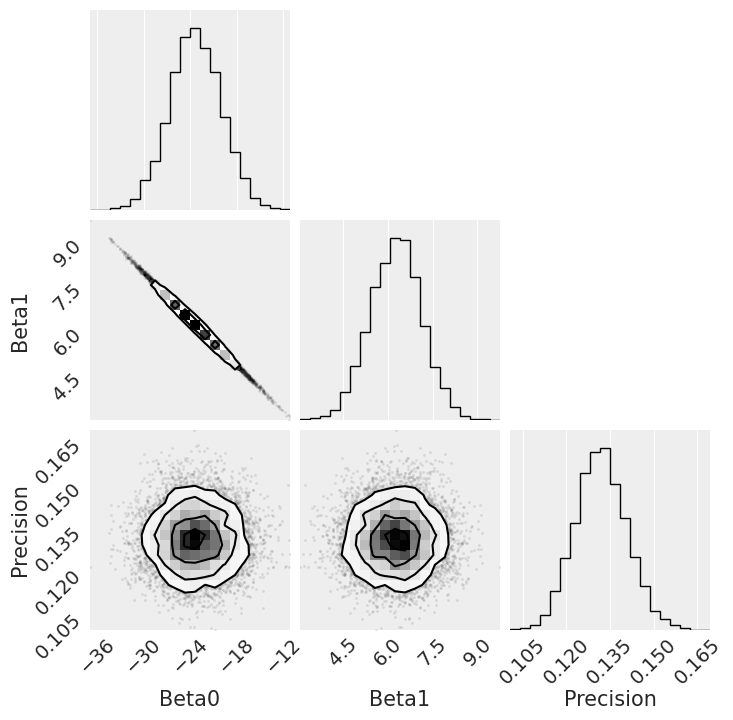

In [51]:
beta0 = trace2.posterior["beta"][1,:,0]
beta1 = trace2.posterior["beta"][1,:,1]
tau = trace2.posterior["tau"][1,:] 
samples = np.vstack([beta0, beta1, tau])
figure = corner.corner(samples.T, labels = ['Beta0','Beta1','Precision'])

Text(0, 0.5, 'Standardized residual')

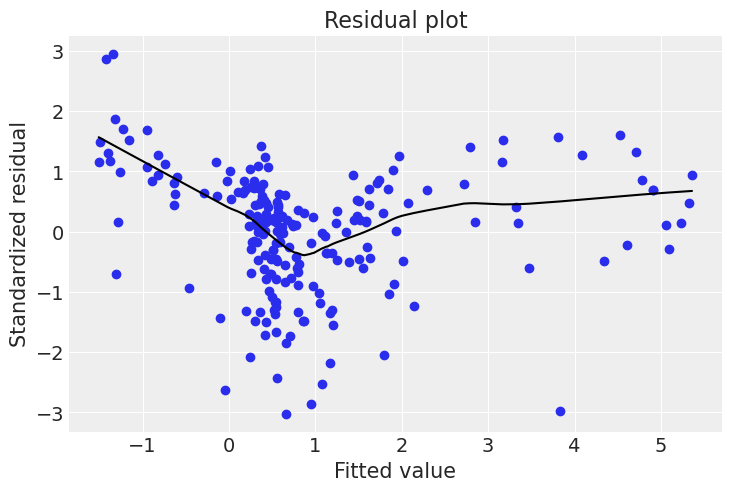

In [53]:
X = np.matrix([np.ones(x.shape[0]),x]).T
temp = np.ones(len(y))
X_matrix = np.matrix([temp,x1]).T
#Coefficients array, which contain beta_0 and beta_1 using their mean posterior density
coef_array = np.array((np.mean(trace2.posterior["beta"][1,:,0]),np.mean(trace2.posterior["beta"][1,:,1])))

fittedY = X_matrix*coef_array[:,None]
#Calculating the residual by subtracting the fitted value by the data
resids = fittedY - y[:,None]
#standardized the residuals
sresids = resids/np.std(resids)

fittedY= fittedY.T
fittedY = np.array((fittedY[0,:]))
fittedY = fittedY[0,:]

sresids = np.array((sresids[:,0]))
sresids = sresids[:,0]


plt.scatter(fittedY,sresids)
#Including the lowess fit
lowess = sm.nonparametric.lowess
fitting=lowess(sresids,fittedY)
plt.plot(fitting[:,0], fitting[:,1], color='black')

plt.plot()
plt.title("Residual plot")
plt.xlabel('Fitted value')
plt.ylabel('Standardized residual')

## Sensitivity analysis for model with error

In [27]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = np.array([1e-3, 1e-3, 5e-3, 1e-4, 1e-5])
d = np.array([1e-3, 1e-3, 5e-3, 1e-4, 1e-5])
e = np.array([0.5, 2 , 3, 4, 5])
f = np.array([0.5, 2,5,9,10])
Posteriors2 = []
for i in range(c.shape[0]):
    print(i)
    basic_model_set4 = Model()

    with basic_model_set4:
        # Priors for unknown model parameters
        tau = Gamma('tau', alpha=e[i], beta=f[i])
        X1 = Normal("X1", mu=0, tau=tau, shape=212)
        beta = Normal('beta', mu=0, tau=d[i], shape=2)
        Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
        # Likelihood (sampling distribution) of observations
        Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
        X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

    map_estimate_set4 = find_MAP(model = basic_model_set4) #*********

    with basic_model_set4: #*********
        start_set4 = find_MAP()  #**********
        #step = pm.Metropolis()
        # draw 1000 posterior samples
        trace_set4 = pm.sample(cores=4, chains=2, start=start_set4, return_inferencedata=True, draws=1000) # step=step
    
    Posteriors2.append(trace_set4)
    print(len(Posteriors2))



0


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/1888136449.py:30: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(cores=4, chains=2, start=start_set4, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


1
1


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/1888136449.py:30: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(cores=4, chains=2, start=start_set4, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


2
2


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/1888136449.py:30: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(cores=4, chains=2, start=start_set4, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


3
3


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/1888136449.py:30: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(cores=4, chains=2, start=start_set4, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


4
4


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_2146/1888136449.py:30: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(cores=4, chains=2, start=start_set4, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


5


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'tau'}>], dtype=object)

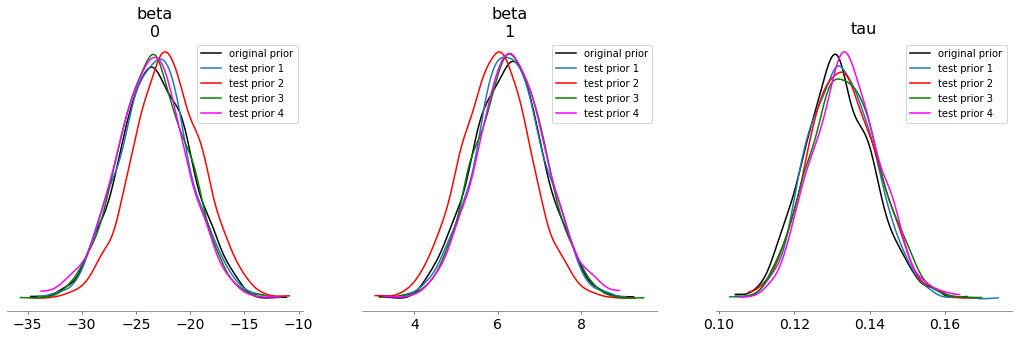

In [29]:
ax1 = az.plot_posterior(Posteriors2[0].posterior[["beta","tau"]], color='black', hdi_prob='hide', point_estimate=None, label='original prior', figsize=(18,5))
az.plot_posterior(Posteriors2[1].posterior[["beta","tau"]], ax=ax1, hdi_prob='hide', point_estimate=None, label='test prior 1')
az.plot_posterior(Posteriors2[2].posterior[["beta","tau"]], ax=ax1, color='red', hdi_prob='hide', point_estimate=None, label='test prior 2')
az.plot_posterior(Posteriors2[3].posterior[["beta","tau"]], ax=ax1, color='green', hdi_prob='hide', point_estimate=None, label='test prior 3')
az.plot_posterior(Posteriors2[4].posterior[["beta","tau"]], ax=ax1, color='magenta', hdi_prob='hide', point_estimate=None, label='test prior 4')

In [26]:
print(len(Posteriors))

1


# Extremely Basic Linear Regression Model

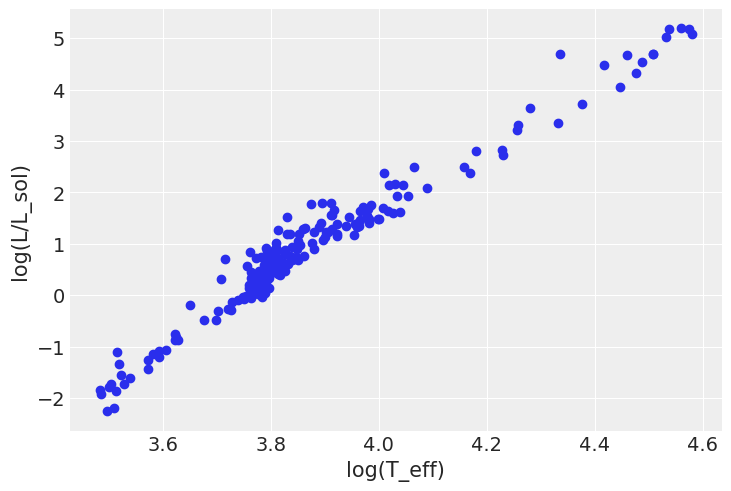

In [294]:
plt.scatter(logT1_cut, logL1_cut)
plt.xlabel("log(T_eff)")
plt.ylabel("log(L/L_sol)")
plt.show()

In [295]:
from sklearn.linear_model import LinearRegression

In [296]:
x = logT1_cut.reshape((-1, 1))
y = logL1_cut

In [297]:
model = LinearRegression()

In [298]:
model = LinearRegression().fit(x, y)

In [300]:
r_sq = model.score(x, y)
print(f"r**2: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

r**2: 0.9589282266653181
intercept: -23.61122802754432
slope: [6.3368916]


In [302]:
print(np.min(logT1_cut))
print(np.max(logT1_cut))

3.483
4.58


In [331]:
x_sp = np.linspace(3.4, 4.66, 1000)
y = (6.337 * x_sp) + -23.611
y_2 = (6.338 * x_sp) + -23.615
y_3 = (6.244 * x_sp) + -23.253

# Comparing All Models:

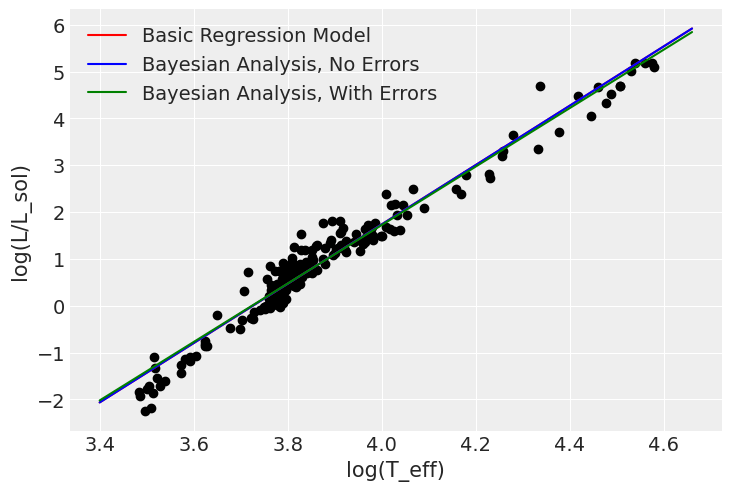

In [332]:
plt.scatter(logT1_cut, logL1_cut, color='black')
plt.plot(x_sp, y, color='red', label='Basic Regression Model')
plt.plot(x_sp, y_2, color='blue', label='Bayesian Analysis, No Errors')
plt.plot(x_sp, y_3, color='green', label='Bayesian Analysis, With Errors')
plt.xlabel("log(T_eff)")
plt.ylabel("log(L/L_sol)")
plt.legend(loc='upper left')
plt.show()

Basic model (scikitt linear regression) and Bayesian analysis model w/out errors are almost identical and therefore cannot be differentiated from one another on the map, Bayesian analysis model w/ errors is slightly different but very close to the other two. 

# Model that include radii data as well as errors:

In [56]:
#Radius data:
logT1 = np.array(df["logT1"])
logT1e = np.array(df["logT1e"])
logL1 = np.array(df["logL1"])
logL1e = np.array(df["logL1e"])
logR1 = np.array(df["logR1"])
logR1e = np.array(df["logR1e"])
logR1 = np.array(df["logR1"])
logR1e = np.array(df["logR1e"])

x1 = logT1
x2 = logR1
y = logL1

ye = logL1e ** (-2)
x1e = logT1e ** (-2)
x2e = logR1e ** (-2)
y_obs = y
x1_obs = x1
x2_obs = x2
c = d = 1e-3
e = f = 0.5


In [57]:
basic_model3 = Model()

with basic_model3:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=logT1.shape[0])
    X2 = Normal("X2", mu=0, tau=tau, shape=logT1.shape[0])

    beta = Normal('beta', mu=0, tau=d, shape=3)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1 + beta[2]*X2, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=ye, observed=y_obs)
    X1_star = Normal('X1_star', mu=X1, tau=x1e, observed=x1_obs)
    X2_star = Normal('X2_star', mu=X2, tau=x2e, observed=x2_obs)

In [58]:
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model3)
pp.pprint(map_estimate)


{   'X1': array([3.48290793, 3.49592198, 3.5099812 , 3.51487628, 3.48557925,
       3.5128931 , 3.52798122, 3.49966625, 3.50379088, 3.53863002,
       3.51799381, 3.57197386, 3.52187663, 3.59290775, 3.57189208,
       3.6049739 , 3.58190772, 3.59284919, 3.62792192, 3.62368601,
       3.79598112, 3.62292012, 3.69880299, 3.78393925, 3.78996268,
       3.62269754, 3.78495138, 3.77189181, 3.79298116, 3.78693929,
       3.67685019, 3.78893937, 3.72585622, 3.77999383, 3.77499386,
       3.74890753, 3.72797396, 3.70187667, 3.75995143, 3.72078894,
       3.76393942, 3.68597391, 3.73995147, 3.75095263, 3.62666723,
       3.69693955, 3.75394996, 3.77696174, 3.64989183, 3.78699386,
       3.75990772, 3.7629215 , 3.77193934, 3.77097386, 3.626659  ,
       3.77296271, 3.76398763, 3.77493912, 3.62484934, 3.76696273,
       3.77298116, 3.7819812 , 3.77096258, 3.78796276, 3.77790764,
       3.77096278, 3.7749812 , 3.63180571, 3.80099386, 3.78098118,
       3.80398759, 3.78296273, 3.77798122, 3.792903

In [59]:
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model3:
    start = find_MAP() 
    #step = pm.Metropolis()
    # draw 10000 posterior samples
    trace3 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000) # step=step

Running on PyMC v4.3.0


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/2478138558.py:12: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace3 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, X2, beta, Y]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 167 seconds.


In [60]:
trace3.posterior.dims

Frozen({'chain': 4, 'draw': 10000, 'X1_dim_0': 262, 'X2_dim_0': 262, 'beta_dim_0': 3, 'Y_dim_0': 262})

In [61]:
posterior = trace3.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 10000, X1_dim_0: 262, X2_dim_0: 262,
                 beta_dim_0: 3, Y_dim_0: 262)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * X1_dim_0    (X1_dim_0) int64 0 1 2 3 4 5 6 7 ... 255 256 257 258 259 260 261
  * X2_dim_0    (X2_dim_0) int64 0 1 2 3 4 5 6 7 ... 255 256 257 258 259 260 261
  * beta_dim_0  (beta_dim_0) int64 0 1 2
  * Y_dim_0     (Y_dim_0) int64 0 1 2 3 4 5 6 7 ... 255 256 257 258 259 260 261
Data variables:
    X1          (chain, draw, X1_dim_0) float64 3.491 3.498 ... 4.618 4.585
    X2          (chain, draw, X2_dim_0) float64 -0.3616 -0.5921 ... 1.001 0.9088
    beta        (chain, draw, beta_dim_0) float64 -16.04 4.284 ... 3.215 2.164
    Y           (chain, draw, Y_dim_0) float64 -1.821 -2.29 ... 5.359 5.087
    tau         (chain, draw) float64 0.1985 0.1922 0.1876 ... 0.1946 0.1984
Attributes:
    created_at:                 2022-11-23T03:42:08.829388
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              166.74575901031494
    tuning_steps:               1000

array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

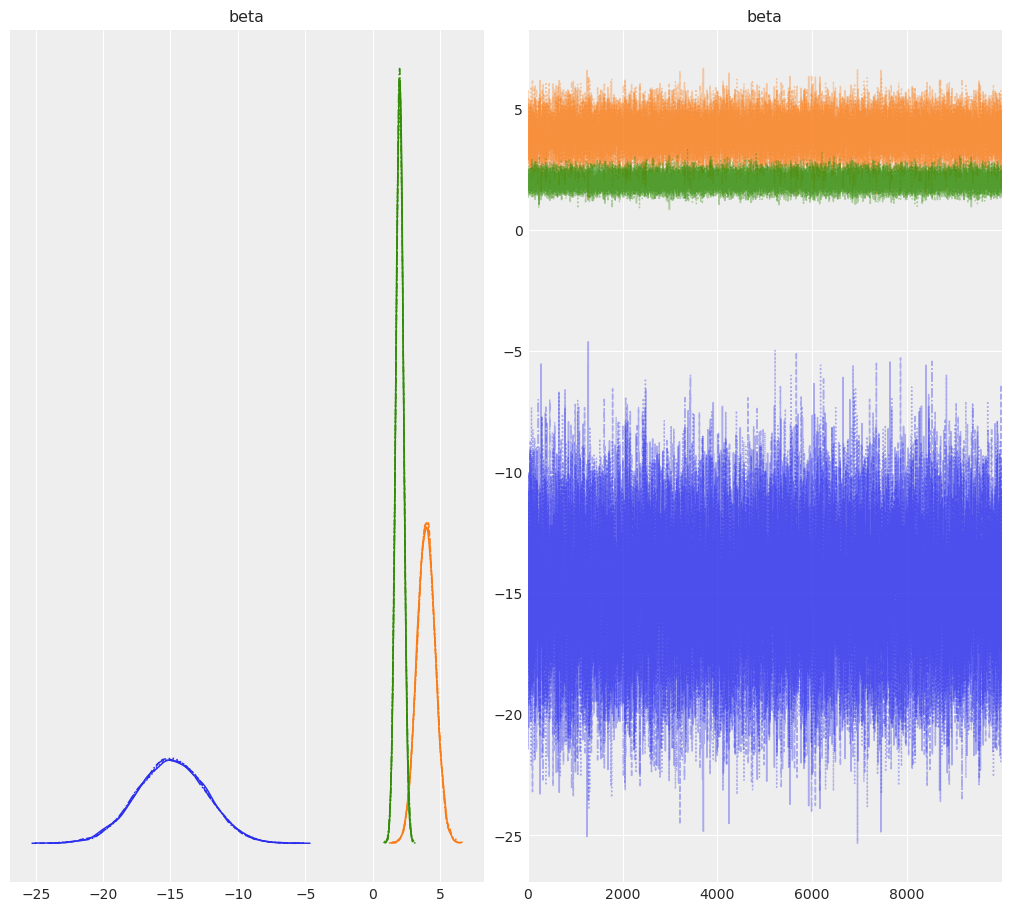

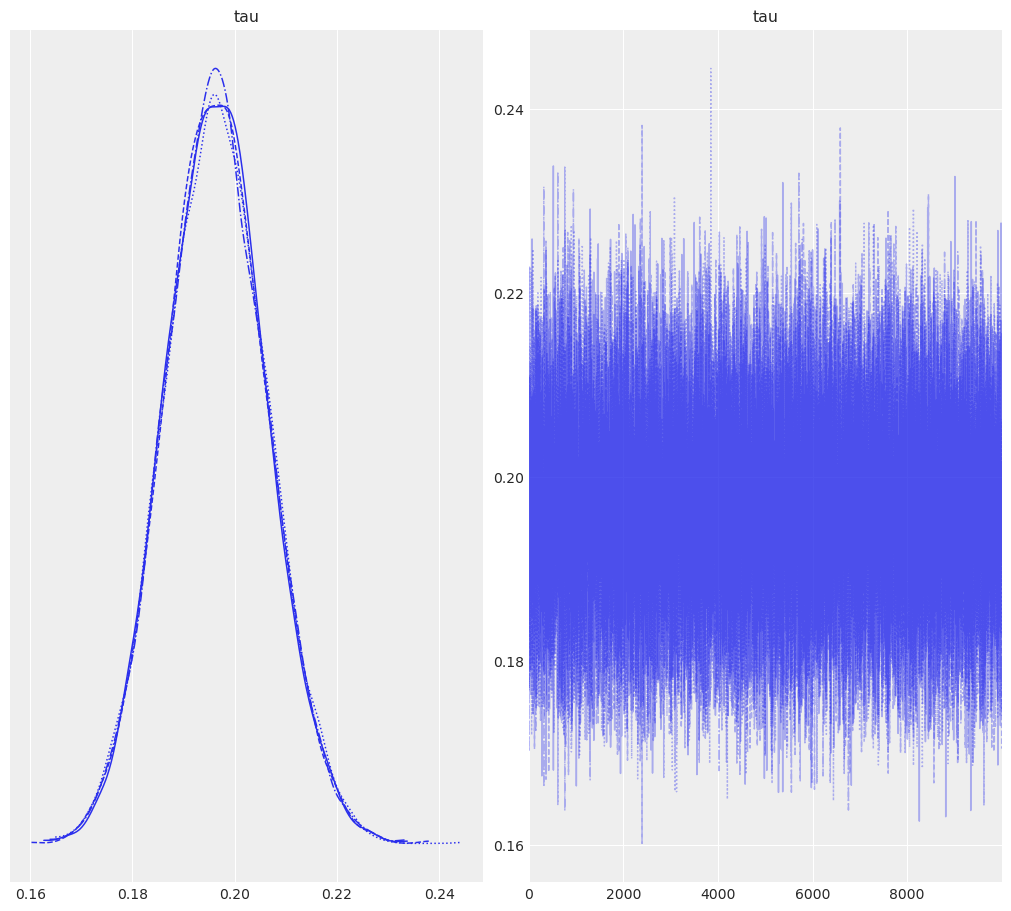

In [62]:
az.plot_trace(trace3.posterior["beta"],figsize=(10, 9))
az.plot_trace(trace3.posterior["tau"],figsize=(10, 9))

In [63]:
az.summary(trace3.posterior[["beta","tau"]], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-14.926,2.561,-19.864,-9.869,0.015,0.011,27804.0,28399.0,1.0
beta[1],3.969,0.671,2.661,5.281,0.004,0.003,27539.0,28273.0,1.0
beta[2],2.002,0.285,1.449,2.560,0.001,0.001,52266.0,30729.0,1.0
tau,0.196,0.010,0.177,0.216,0.000,0.000,61409.0,29816.0,1.0


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'beta\n2'}>,
       <AxesSubplot:title={'center':'tau'}>], dtype=object)

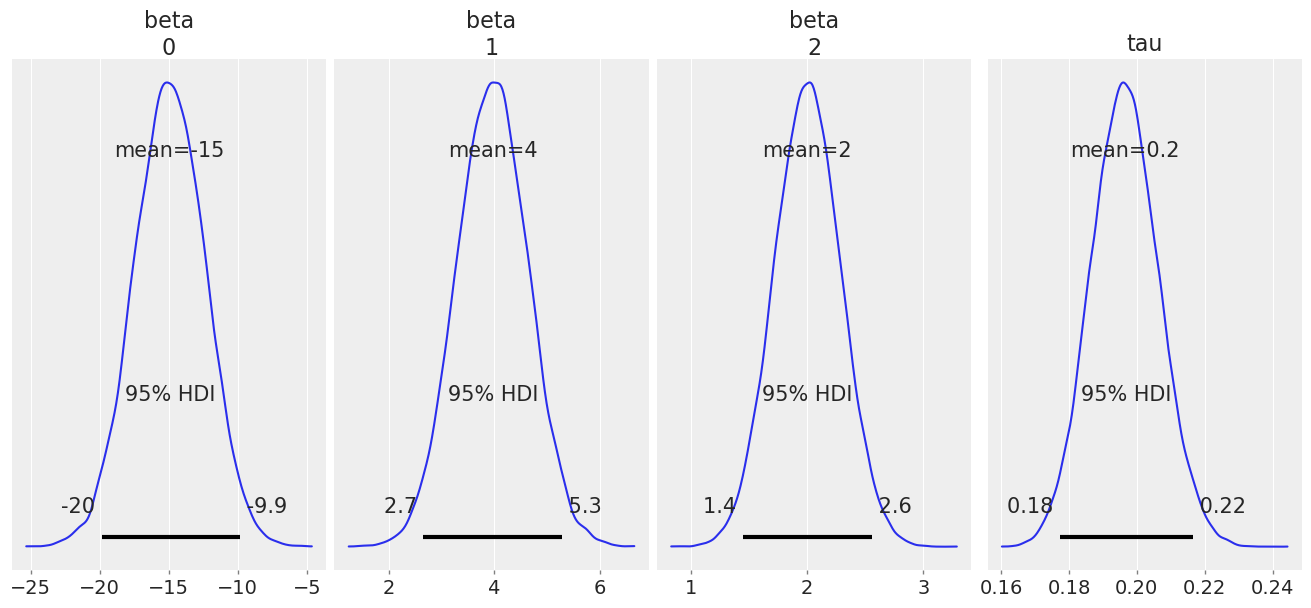

In [64]:
az.plot_posterior(trace3.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'beta\n2'}>,
       <AxesSubplot:title={'center':'tau'}>], dtype=object)

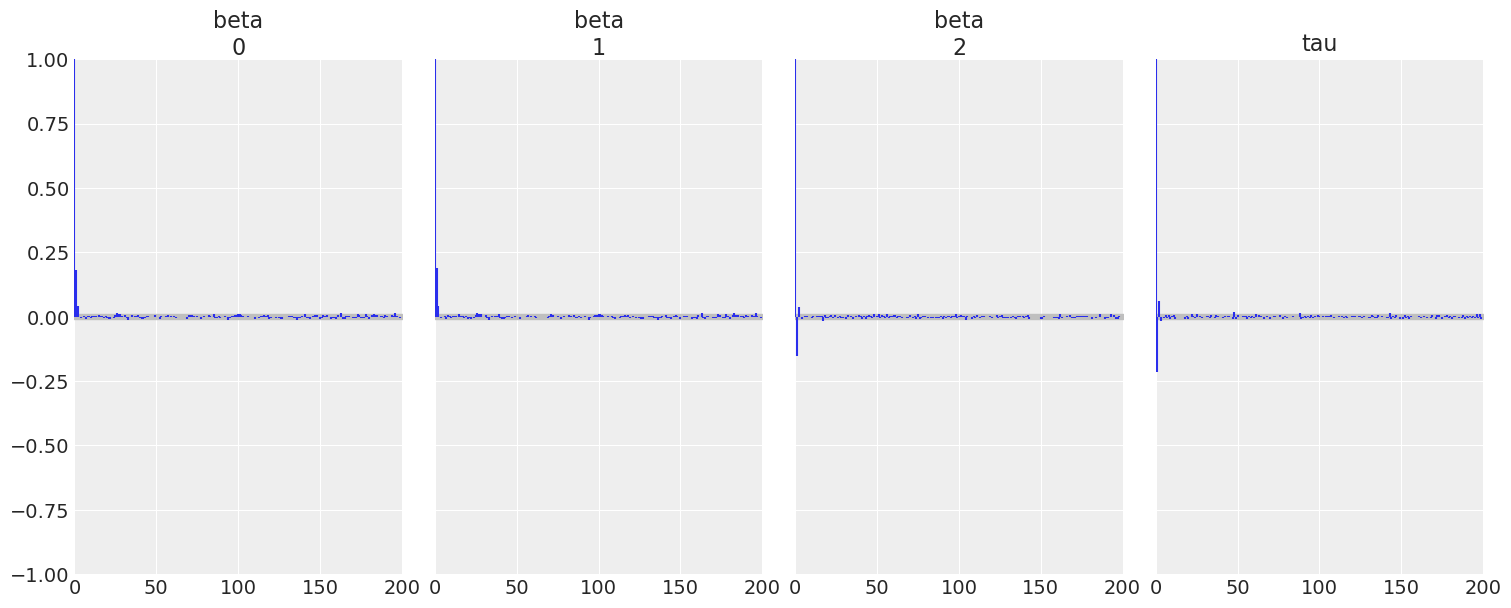

In [65]:
az.plot_autocorr(trace3, var_names=['beta','tau'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))

In [66]:
with basic_model3:
    pm.sample_posterior_predictive(trace3, extend_inferencedata=True)

Sampling: [X1_star, X2_star, Y_star]


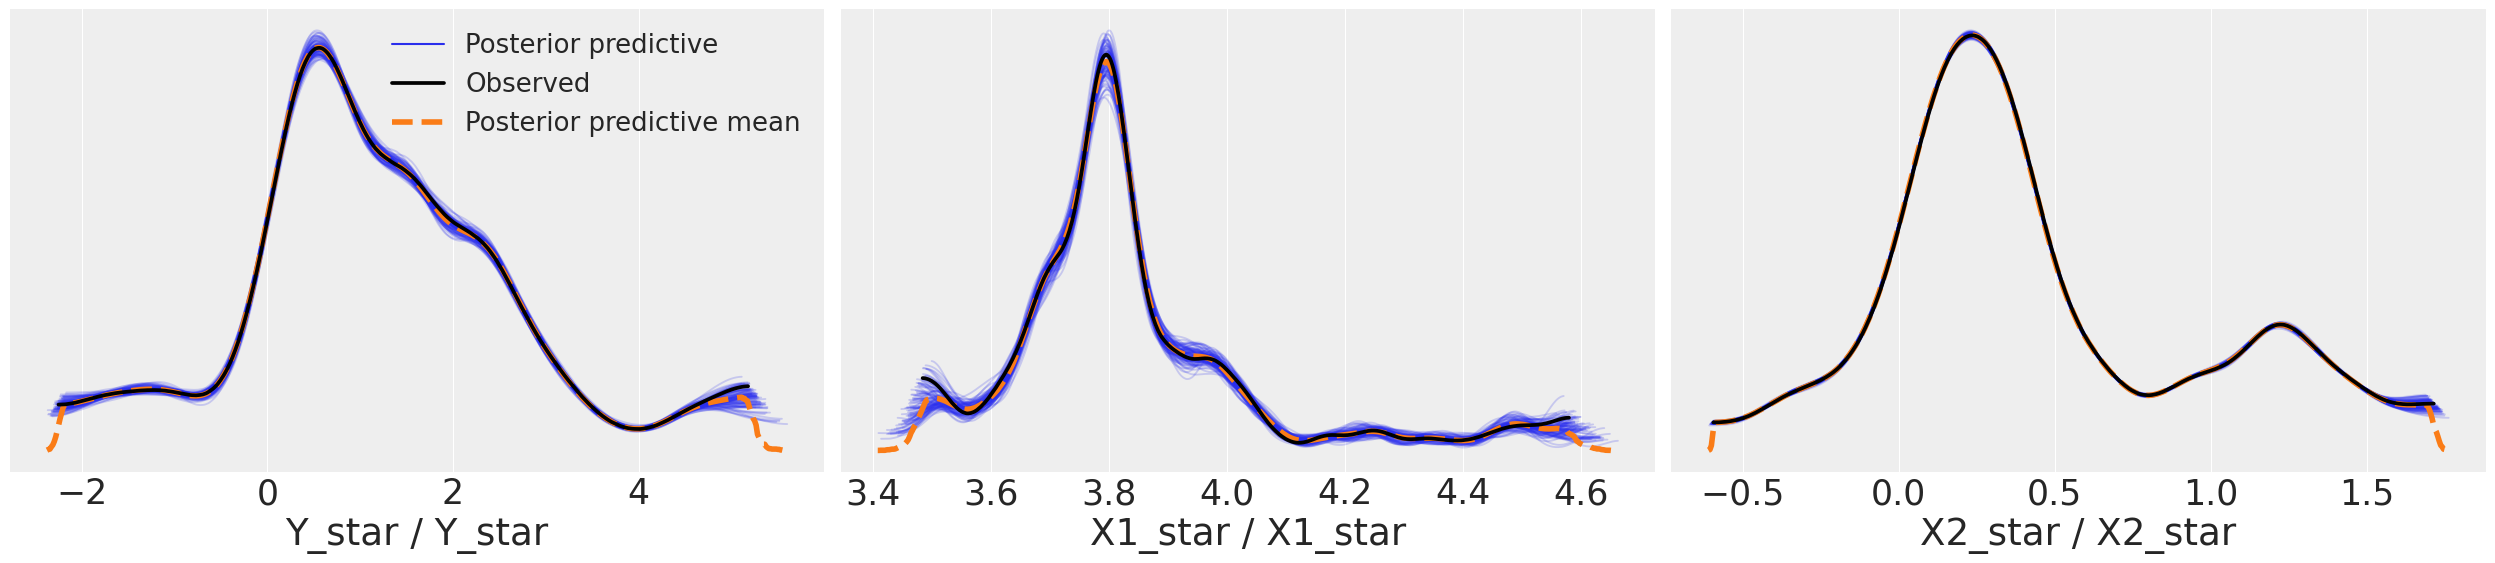

In [67]:
az.plot_ppc(trace3, num_pp_samples=100, textsize=25);

/Users/kietpham/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


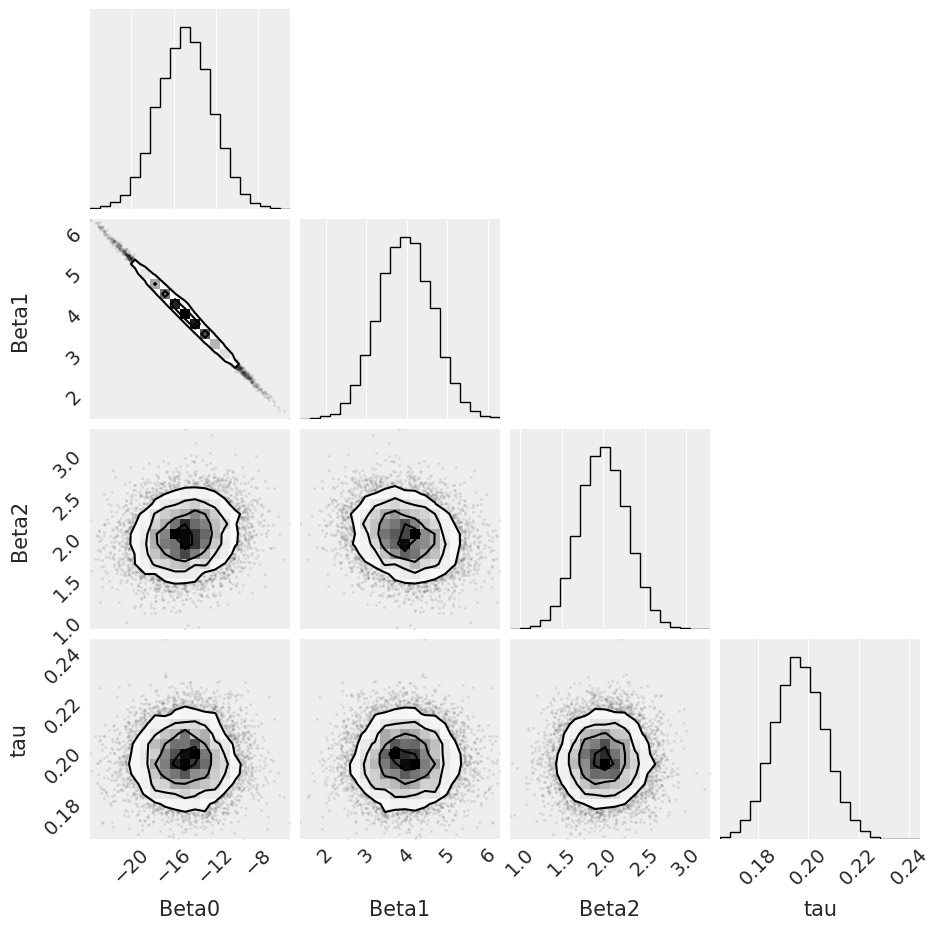

In [69]:
beta0 = trace3.posterior["beta"][1,:,0]
beta1 = trace3.posterior["beta"][1,:,1]
beta2 = trace3.posterior["beta"][1,:,2]

tau = trace3.posterior["tau"][1,:] 
samples = np.vstack([beta0, beta1,beta2,tau])
figure = corner.corner(samples.T, labels = ['Beta0','Beta1', 'Beta2', 'tau'])

Text(0, 0.5, 'Standardized residual')

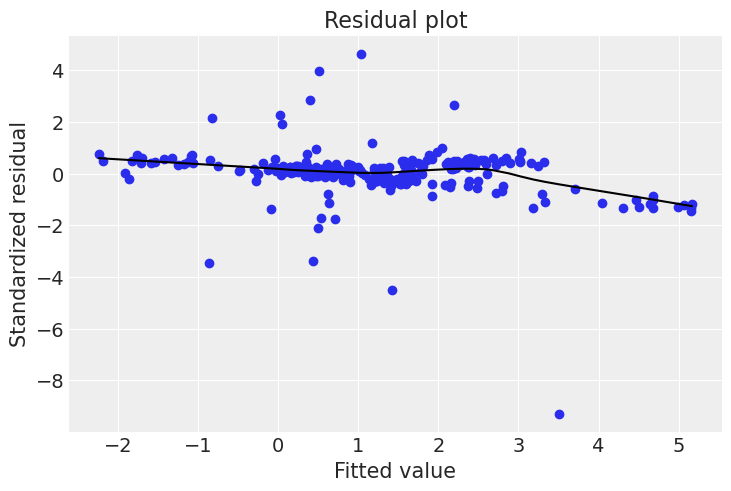

In [74]:
X = np.matrix([np.ones(x.shape[0]),x]).T
temp = np.ones(len(y))
X_matrix = np.matrix([temp,x1,x2]).T
#Coefficients array, which contain beta_0 and beta_1 using their mean posterior density
coef_array = np.array((np.mean(beta0),np.mean(beta1),np.mean(beta2)))

fittedY = X_matrix*coef_array[:,None]
#Calculating the residual by subtracting the fitted value by the data
resids = fittedY - y[:,None]
#standardized the residuals
sresids = resids/np.std(resids)

fittedY= fittedY.T
fittedY = np.array((fittedY[0,:]))
fittedY = fittedY[0,:]

sresids = np.array((sresids[:,0]))
sresids = sresids[:,0]


plt.scatter(fittedY,sresids)
#Including the lowess fit
lowess = sm.nonparametric.lowess
fitting=lowess(sresids,fittedY)
plt.plot(fitting[:,0], fitting[:,1], color='black')

plt.plot()
plt.title("Residual plot")
plt.xlabel('Fitted value')
plt.ylabel('Standardized residual')

# Sensitivity analysis for the models that include radii and errors data

In [95]:


c = d = 1e-3
e = np.array([3, 4, 5, 10])
e2= np.array([3, 4, 2, 1])
f = np.array([5, 7, 9, 12])
f2= np.array([5, 7, 3, 0.5])
g = np.array([3, 4, 8, 5])
j = np.array([5, 7, 0.5, 1])
steps = 1000
beta1 = np.zeros((steps, 4))
beta2 = np.zeros((steps, 4))
for i in range(e.shape[0]):
    basic_model4 = Model()
    with basic_model4:
        # Priors for unknown model parameters
        taux1= Gamma('taux1', alpha=e[i], beta=f[i])
        taux2= Gamma('taux2', alpha=e2[i], beta=f2[i])
        tauy = Gamma('tauy', alpha=g[i], beta=j[i])
        X1 = Normal("X1", mu=0, tau=taux1, shape=logT1.shape[0])
        X2 = Normal("X2", mu=0, tau=taux2, shape=logT1.shape[0])

        beta = Normal('beta', mu=0, tau=d, shape=3)
        Y = Normal("Y", mu=beta[0] + beta[1]*X1 + beta[2]*X2, tau=tauy)
        # Likelihood (sampling distribution) of observations
        Y_star = Normal('Y_star', mu=Y, tau=ye, observed=y_obs)
        X1_star = Normal('X1_star', mu=X1, tau=x1e, observed=x1_obs)
        X2_star = Normal('X2_star', mu=X2, tau=x2e, observed=x2_obs)


    pp = pprint.PrettyPrinter(indent=4)
    map_estimate = find_MAP(model = basic_model4)
    pp.pprint(map_estimate)

    with basic_model4:
        start = find_MAP() 
        # draw 1000 posterior samples
        trace4 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
    
    beta1[:,i] = trace4.posterior["beta"][1,:,1]
    beta2[:,i] = trace4.posterior["beta"][1,:,2]

    

# az.summary(trace4.posterior[["beta","tau"]], hdi_prob=0.95)
# az.plot_posterior(trace4.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)


{   'X1': array([3.48301263, 3.49596175, 3.51000094, 3.51496432, 3.48637177,
       3.51313574, 3.52800343, 3.4998605 , 3.50399065, 3.53910278,
       3.51799794, 3.57198863, 3.52200893, 3.59298867, 3.57199966,
       3.60499287, 3.58198568, 3.59288538, 3.62795811, 3.6259362 ,
       3.79598573, 3.62272092, 3.69899738, 3.78397674, 3.78997569,
       3.62297221, 3.78496579, 3.77195036, 3.79299092, 3.78698119,
       3.67700634, 3.78899233, 3.72609848, 3.77999394, 3.77499718,
       3.74895778, 3.72799371, 3.70197438, 3.75997319, 3.72103902,
       3.76400023, 3.68598852, 3.73997931, 3.75113793, 3.62697417,
       3.69702522, 3.75377405, 3.77684753, 3.6499621 , 3.78699804,
       3.75998233, 3.76290864, 3.77198832, 3.77097806, 3.62738835,
       3.7729802 , 3.7639974 , 3.77495882, 3.62491161, 3.76698318,
       3.77299068, 3.78199632, 3.77096329, 3.78798658, 3.77797135,
       3.77099023, 3.77499719, 3.6320444 , 3.80099698, 3.78099365,
       3.80399229, 3.7829838 , 3.77799934, 3.792472

/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/2363730305.py:36: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace4 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [taux1, taux2, tauy, X1, X2, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.



{   'X1': array([3.48301327, 3.49596509, 3.50999977, 3.51496705, 3.48626557,
       3.51309251, 3.5280018 , 3.49989859, 3.50401731, 3.53904096,
       3.5179973 , 3.57199062, 3.52199941, 3.59299475, 3.57199119,
       3.60499368, 3.58199272, 3.59291272, 3.62796071, 3.62551674,
       3.79598837, 3.62278585, 3.69897723, 3.78398029, 3.78997554,
       3.62296084, 3.78497124, 3.77195155, 3.79299211, 3.78698356,
       3.67699911, 3.78899159, 3.72608668, 3.77999418, 3.77499651,
       3.74897114, 3.72799398, 3.70197224, 3.75997664, 3.72104751,
       3.76399746, 3.68599007, 3.7399812 , 3.75109717, 3.62695812,
       3.69701551, 3.75383084, 3.7768819 , 3.64996137, 3.78699713,
       3.75998923, 3.76292369, 3.77198882, 3.77098249, 3.62684573,
       3.7729788 , 3.76399685, 3.77496734, 3.62492643, 3.76698095,
       3.77299196, 3.78199604, 3.77096649, 3.78798345, 3.77798102,
       3.7709861 , 3.77499669, 3.63194514, 3.80099634, 3.78099408,
       3.80399312, 3.78298137, 3.77799823, 3.792611

/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/2363730305.py:36: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace4 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [taux1, taux2, tauy, X1, X2, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.



{   'X1': array([3.48317186, 3.49586222, 3.51004486, 3.51496802, 3.4871441 ,
       3.51396071, 3.52806306, 3.49983712, 3.50403408, 3.53916993,
       3.51800226, 3.57197695, 3.52216521, 3.59305913, 3.57215974,
       3.60501059, 3.58206396, 3.59268128, 3.62787949, 3.62997932,
       3.79593576, 3.6215315 , 3.69917336, 3.78398205, 3.78992051,
       3.62307217, 3.78486742, 3.77195117, 3.79297781, 3.78701418,
       3.67719984, 3.78908227, 3.72662724, 3.77997299, 3.77500356,
       3.74892445, 3.72802468, 3.70206054, 3.75991153, 3.72128057,
       3.76413243, 3.68596952, 3.73995298, 3.75202565, 3.62706424,
       3.69720588, 3.75258753, 3.77601562, 3.64998249, 3.78701196,
       3.76005511, 3.76259791, 3.7720579 , 3.77091255, 3.62672641,
       3.77295224, 3.76403333, 3.77485667, 3.62475341, 3.76697039,
       3.77297461, 3.78202465, 3.77082815, 3.78800018, 3.77800659,
       3.77102455, 3.77501937, 3.63220257, 3.80100173, 3.78099938,
       3.8039901 , 3.78297843, 3.77804707, 3.790273

/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/2363730305.py:36: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace4 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [taux1, taux2, tauy, X1, X2, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.



{   'X1': array([3.48312405, 3.49592793, 3.51002632, 3.51497853, 3.48696793,
       3.51364018, 3.52803667, 3.49989462, 3.50403584, 3.5390875 ,
       3.51800191, 3.57198752, 3.52211867, 3.59303483, 3.57211702,
       3.60500656, 3.58204919, 3.59274941, 3.6279153 , 3.62892376,
       3.79596141, 3.62202824, 3.69909699, 3.78398226, 3.78994751,
       3.62307331, 3.78490899, 3.77195739, 3.79298491, 3.78699962,
       3.67714592, 3.78904142, 3.72647417, 3.77998479, 3.77500048,
       3.74894284, 3.7280122 , 3.7020226 , 3.7599375 , 3.72120035,
       3.76407373, 3.68598352, 3.73996288, 3.75161493, 3.62707641,
       3.69714161, 3.75312674, 3.77640882, 3.64999016, 3.78700469,
       3.76003635, 3.76273041, 3.77202735, 3.77094596, 3.62710086,
       3.77296641, 3.76401457, 3.77490624, 3.62481765, 3.76697741,
       3.77298314, 3.78200991, 3.7708938 , 3.78799401, 3.7779977 ,
       3.77100877, 3.77500955, 3.63217131, 3.80099954, 3.78099779,
       3.80399098, 3.78298136, 3.77802284, 3.791176

/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_11786/2363730305.py:36: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace4 = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [taux1, taux2, tauy, X1, X2, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


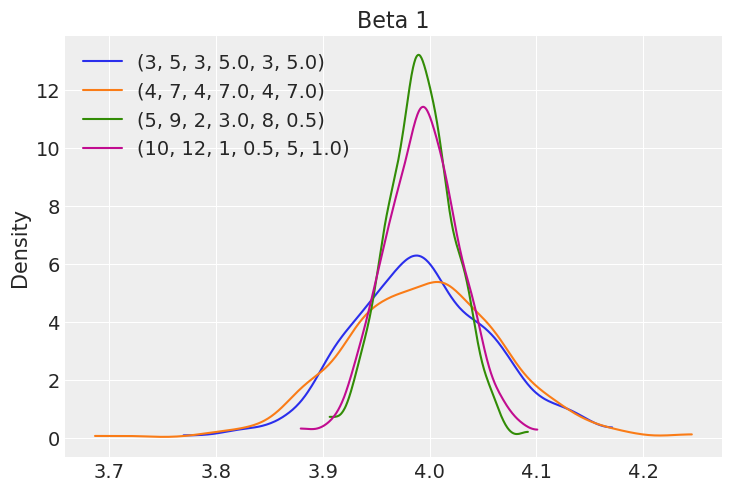

In [97]:
arr1 = az.plot_dist(beta1[:,0], color='C0', label = '(' + str(e[0]) + ', ' + str(f[0]) + ', '+ str(e2[0]) + ', ' + str(f2[0]) + ', ' + str(g[0]) + ', ' + str(j[0]) +')' )
arr2 = az.plot_dist(beta1[:,1], color='C1', label ='(' + str(e[1]) + ', ' + str(f[1]) + ', '+ str(e2[1]) + ', ' + str(f2[1]) + ', ' + str(g[1]) + ', ' + str(j[1]) +')' )
arr3 = az.plot_dist(beta1[:,2], color='C2', label ='(' + str(e[2]) + ', ' + str(f[2]) + ', '+ str(e2[2]) + ', ' + str(f2[2]) + ', ' + str(g[2]) + ', ' + str(j[2]) + ')' )
arr4 = az.plot_dist(beta1[:,3], color='C3', label ='(' + str(e[3]) + ', ' + str(f[3]) + ', '+ str(e2[3]) + ', ' + str(f2[3]) + ', ' + str(g[3]) + ', ' + str(j[3]) + ')' )

plt.ylabel('Density')
plt.title('Beta 1')
plt.legend(frameon=False)


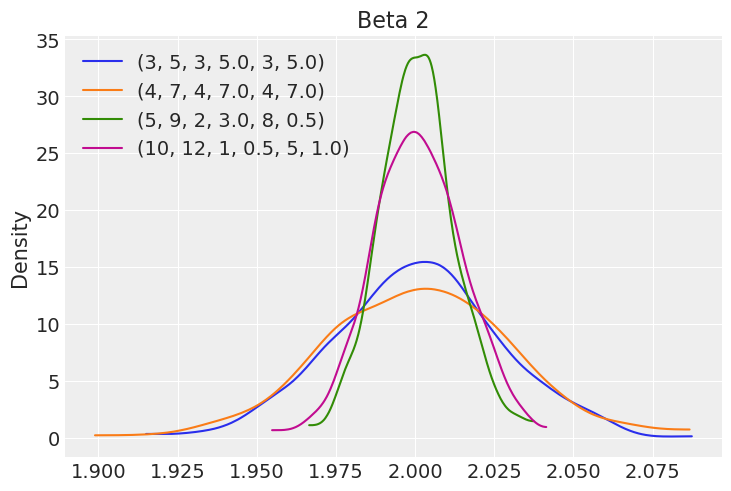

In [98]:
arr1 = az.plot_dist(beta2[:,0], color='C0', label = '(' + str(e[0]) + ', ' + str(f[0]) + ', '+ str(e2[0]) + ', ' + str(f2[0]) + ', ' + str(g[0]) + ', ' + str(j[0]) +')' )
arr2 = az.plot_dist(beta2[:,1], color='C1', label ='(' + str(e[1]) + ', ' + str(f[1]) + ', '+ str(e2[1]) + ', ' + str(f2[1]) + ', ' + str(g[1]) + ', ' + str(j[1]) +')' )
arr3 = az.plot_dist(beta2[:,2], color='C2', label ='(' + str(e[2]) + ', ' + str(f[2]) + ', '+ str(e2[2]) + ', ' + str(f2[2]) + ', ' + str(g[2]) + ', ' + str(j[2]) + ')' )
arr4 = az.plot_dist(beta2[:,3], color='C3', label ='(' + str(e[3]) + ', ' + str(f[3]) + ', '+ str(e2[3]) + ', ' + str(f2[3]) + ', ' + str(g[3]) + ', ' + str(j[3]) + ')' )

plt.ylabel('Density')
plt.title('Beta 2')
plt.legend(frameon=False)
